In [1]:
import numpy as np
import pandas as pd
import glob
import re

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Embedding, LSTM, \
                                    Bidirectional, Dense,\
                                    Dropout
import tensorflow_datasets as tfds

from bs4 import BeautifulSoup


tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


# Training Data Vectorization

In [2]:
def load_reviews(path, columns=["filename", 'review']):
    assert len(columns) == 2
    l = list()
    for filename in glob.glob(path):
        # print(filename)
        with open(filename, 'r') as f:
            review = f.read()
            l.append((filename, review))
    return pd.DataFrame(l, columns=columns)

#unsup_df = load_reviews("./aclImdb/train/unsup/*.txt")

def load_labelled_data(path, neg='/neg/',
                       pos='/pos/', shuffle=True):
    neg_df = load_reviews(path + neg + "*.txt")
    pos_df = load_reviews(path + pos + "*.txt")
    neg_df['sentiment'] = 0
    pos_df['sentiment'] = 1
    df = pd.concat([neg_df, pos_df], axis=0)
    if shuffle:
        df = df.sample(frac=1, random_state=42)
    return df

train_df = load_labelled_data("./aclImdb/train/")

def fn_to_score(f):
    scr = f.split("/")[-1]  # get file name
    scr = scr.split(".")[0] # remove extension
    scr = int(scr.split("_")[-1]) #the score
    return scr

train_df['score'] = train_df.filename.apply(fn_to_score)
train_df.head()

test_df = load_labelled_data("./aclImdb/test/")

# load encoder
imdb_encoder = tfds.features.text.SubwordTextEncoder.\
                load_from_file("imdb")

In [3]:
# we need a sample of 2000 reviews for training
num_recs = 2000

train_small = pd.read_pickle("train_2k.df")
# we dont need the snorkel column
train_small = train_small.drop(columns=['snorkel'])

# remove markup
cleaned_reviews = train_small.review.apply(lambda x: BeautifulSoup(x).text)
# convert pandas DF in to tf.Dataset
train = tf.data.Dataset.from_tensor_slices((cleaned_reviews.values,
                                            train_small.sentiment.values))

In [4]:
# transformation functions to be used with the dataset

def encode_pad_transform(sample):
    encoded = imdb_encoder.encode(sample.numpy())
    pad = sequence.pad_sequences([encoded], padding='post',
                                 maxlen=150)
    return np.array(pad[0], dtype=np.int64)


def encode_tf_fn(sample, label):
    encoded = tf.py_function(encode_pad_transform,
                                       inp=[sample],
                                       Tout=(tf.int64))
    encoded.set_shape([None])
    label.set_shape([])
    return encoded, label

encoded_train = train.map(encode_tf_fn,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Test Data Vectorization

In [5]:
# remove markup
cleaned_test_reviews = test_df.review.apply(lambda x: BeautifulSoup(x).text)
# convert pandas DF in to tf.Dataset
test = tf.data.Dataset.from_tensor_slices((cleaned_test_reviews.values,
                                            test_df.sentiment.values))
encoded_test = test.map(encode_tf_fn,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Baseline Model

In [6]:
# Length of the vocabulary
vocab_size = imdb_encoder.vocab_size

# Number of RNN units
rnn_units = 64

# Embedding size
embedding_dim = 64

#batch size
BATCH_SIZE=100

dropout=0.3
def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size, dropout=0.):
  model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True,
                              batch_input_shape=[batch_size, None]),
    Bidirectional(LSTM(rnn_units, return_sequences=True,
                      dropout=dropout)),
    Dropout(dropout),
    Bidirectional(tf.keras.layers.LSTM(rnn_units, dropout=dropout)),
    Dropout(dropout),
    Dense(1, activation='sigmoid')
  ])
  return model


In [7]:
bilstm = build_model_bilstm(vocab_size = vocab_size,
        embedding_dim=embedding_dim,
        rnn_units=rnn_units,  batch_size=BATCH_SIZE,
        dropout=dropout)
bilstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy', 'Precision', 'Recall'])

encoded_train_batched = encoded_train.shuffle(num_recs, seed=42).\
                                    batch(BATCH_SIZE)
bilstm.fit(encoded_train_batched, epochs=15)
bilstm.evaluate(encoded_test.batch(BATCH_SIZE))
print("BASELINE TRAINED")

Train for 20 steps
Epoch 1/15
20/20 [==============================] - 16s 793ms/step - loss: 0.6943 - accuracy: 0.4795 - Precision: 0.4833 - Recall: 0.5940
Epoch 2/15
20/20 [==============================] - 4s 205ms/step - loss: 0.6509 - accuracy: 0.6690 - Precision: 0.7507 - Recall: 0.5060
Epoch 3/15
20/20 [==============================] - 4s 205ms/step - loss: 0.3906 - accuracy: 0.8400 - Precision: 0.8353 - Recall: 0.8470
Epoch 4/15
20/20 [==============================] - 4s 207ms/step - loss: 0.1462 - accuracy: 0.9455 - Precision: 0.9372 - Recall: 0.9550
Epoch 5/15
20/20 [==============================] - 4s 206ms/step - loss: 0.0590 - accuracy: 0.9785 - Precision: 0.9848 - Recall: 0.9720
Epoch 6/15
20/20 [==============================] - 4s 205ms/step - loss: 0.0115 - accuracy: 0.9975 - Precision: 0.9970 - Recall: 0.9980
Epoch 7/15
20/20 [==============================] - 4s 207ms/step - loss: 0.0049 - accuracy: 0.9995 - Precision: 1.0000 - Recall: 0.9990
Epoch 8/15
20/20 [===

# With Snorkel Labeled Data

showing hist of additional data


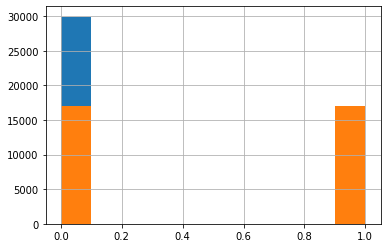

In [8]:
# labelled version of training data split
p1 = pd.read_pickle("snorkel_train_labeled.df")

p2 = pd.read_pickle("snorkel-unsup-nbs-v2.df")
p2 = p2.drop(columns=['snorkel']) # so that everything aligns

# now concatenate the three DFs
p2 = pd.concat([train_small, p1, p2]) # training plus snorkel labelled data
print("showing hist of additional data")

# now balance the labels
pos = p2[p2.sentiment == 1]
neg = p2[p2.sentiment == 0]
recs = min(pos.shape[0], neg.shape[0])
pos = pos.sample(n=recs, random_state=42)
neg = neg.sample(n=recs, random_state=42)

p3 = pd.concat((pos,neg))
p3.sentiment.hist()

In [11]:
p3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33914 entries, 6975 to 7453
Data columns (total 3 columns):
filename     33914 non-null object
review       33914 non-null object
sentiment    33914 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [9]:
# remove markup
cleaned_unsup_reviews = p3.review.apply(lambda x: BeautifulSoup(x).text)
snorkel_reviews = pd.concat((cleaned_reviews, cleaned_unsup_reviews))
snorkel_labels = pd.concat((train_small.sentiment, p3.sentiment))

# convert pandas DF in to tf.Dataset
snorkel_train = tf.data.Dataset.from_tensor_slices((snorkel_reviews.values,
                                            snorkel_labels.values))
encoded_snorkel_train = snorkel_train.map(encode_tf_fn,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [10]:
# Length of the vocabulary
vocab_size = imdb_encoder.vocab_size

# Number of RNN units
rnn_units = 64

# Embedding size
embedding_dim = 64

#batch size
BATCH_SIZE = 100

dropout = 0.3
bilstm2 = build_model_bilstm(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE,
  dropout=dropout)

bilstm2.summary()

bilstm2.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy', 'Precision', 'Recall'])

shuffle_size = snorkel_reviews.shape[0] // BATCH_SIZE * BATCH_SIZE
encoded_snorkel_batched = encoded_snorkel_train.shuffle(buffer_size=shuffle_size,
                                        seed=42).batch(BATCH_SIZE,
                                        drop_remainder=True)

bilstm2.fit(encoded_snorkel_batched, epochs=20)

print("Checking on Test Set:")
bilstm2.evaluate(encoded_test.batch(BATCH_SIZE))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (100, None, 64)           529024    
_________________________________________________________________
bidirectional_2 (Bidirection (100, None, 128)          66048     
_________________________________________________________________
dropout_2 (Dropout)          (100, None, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (100, 128)                98816     
_________________________________________________________________
dropout_3 (Dropout)          (100, 128)                0         
_________________________________________________________________
dense_1 (Dense)              (100, 1)                  129       
Total params: 694,017
Trainable params: 694,017
Non-trainable params: 0
________________________________________________

[1.2806373039484025, 0.76232, 0.76965463, 0.74872]